# Nuts and Bolts Project
**Course**: CS 4732

**Instr**: Dr. Hung

Test 2, Part 1 (Take Home)

## Description
You are asked to classify parts coming down a conveyor line as nuts, bolts or washers.
Please write your program in any programming languages to implement this pattern recognition
problem. Some images are provided for your experiments.

Example Image:
<img src="https://github.com/mtfuller/CS4732-Nuts-and-Bolts/raw/master/img/bolts2.jpg" alt="Example Image" style="width: 400px;"/>

Please note that this is not just *image segmentaion* problem. It is a *pattern recognition* problem. You
are encouraged to create your own images similar to the one shown below as long as your images
have nuts, bolts and washers.

Turn in:
 1. One page for your recognition system design,
 2. Your program, and
 3. Your demo.

## Design
To classify the parts in the image, we need to design a solution that can accomplish three major tasks:
 - Segment the individual objects in the image.
 - Extract a certain number of features each segmented object.
 - Classify the object based on the extracted features.
 
Here is an overview of the entire process:
![Example Image](https://github.com/mtfuller/CS4732-Nuts-and-Bolts/raw/master/img/NutsBoltsDataflow.png "Example Nuts/Bolts Image")

To implement the solution, I have chosen to use Python along with various libraries such as OpenCV, TensorFlow, Keras, etc. in order to more easily implement the designed process.

## Object Segmentation
Objective: create a process to take an input image and find all possible objects and create a create a list of all matrices that contain objects to use for feature extraction.

First, let's load an example image:

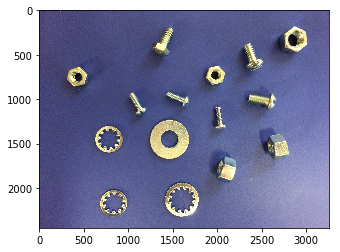

In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

%matplotlib inline

input_file = './img/bolts.png'

original = cv2.imread(input_file,1)
plt.imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))

A big question to answer is: what is the best way to find and extract the parts from the image? We need a way to segment the image in a way that allows us to find each individual part. Color-based segmentation using K-Means would not be a good fit for this problem. An alternative is to use morphological operators to perform texture segmentation on the object.

Reference on OpenCV Morphological Operators: [OpenCV Python Tutorial](https://docs.opencv.org/3.0-beta/doc/py_tutorials/py_imgproc/py_morphological_ops/py_morphological_ops.html)

We can use a *Morphological Gradient* to place outlines around each object in the image:

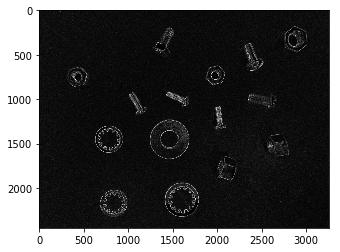

In [2]:
small_kernel = np.ones((5,5),np.uint8)

gray_image = cv2.imread(input_file,0)
gradient = cv2.morphologyEx(gray_image, cv2.MORPH_GRADIENT, small_kernel)
plt.imshow(gradient,cmap='gray')

Now, let's find the binary regions in the image that represent the objects. We can do this by applying a binary threshold and then close the image:

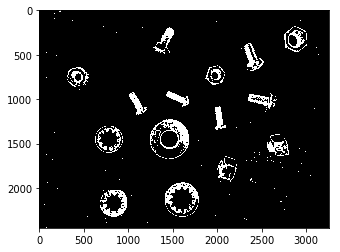

In [3]:
med_kernel = np.ones((9,9),np.uint8)

# Closing Image
closing = cv2.morphologyEx(gradient, cv2.MORPH_CLOSE, med_kernel)

# Thresholding
ret,thresh1 = cv2.threshold(closing,35,255,cv2.THRESH_BINARY)

# th3 = cv2.adaptiveThreshold(gradient,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
#             cv2.THRESH_BINARY,11,2)

# Closing Image
# closing = cv2.morphologyEx(thresh1, cv2.MORPH_CLOSE, med_kernel)

plt.imshow(thresh1,cmap='gray')

At this point, we have a binary image where most white pixels are a part of one of the objects. Now we need to extract the individual objects from the image. We can do this by calculating each object's minimum bounding box.

Total contours found: 604
Number of Objects: 15


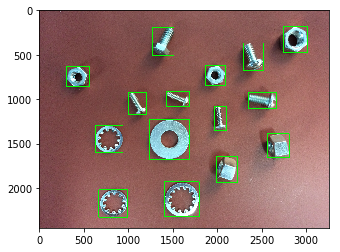

In [4]:
rects, contours, h = cv2.findContours(thresh1, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

new = original.copy()

min_area = 0.001
max_area = 0.9

parts = []

print("Total contours found:",len(contours))
num_of_objects = 0
for i in range(len(contours)):
    cnt = contours[i]
    x,y,w,h = cv2.boundingRect(cnt)
    area_ratio = (w*h) / (new.shape[0] * new.shape[1])
    if (area_ratio >= min_area and area_ratio <= max_area):
        num_of_objects += 1
        parts.append(tuple([x,y,w,h]))
        new = cv2.rectangle(new,(x,y),(x+w,y+h),(0,255,0),10)

print("Number of Objects:",num_of_objects)
plt.imshow(new)

Now, we have calculated the minimum bounding box for each object in the image. The object segmentation phase is now complete.

## Feature Extraction
The next phase in creating a solution to this pattern recognition is to extract specific features from each object. 

Let's evalutate some possible features:
 - **Color**: Not a good feature, parts can come in multiple colors.
 - **Size**: Not a good feature, parts often vary in size.
 - **Outer Shape of Object**: Good feature, but difficult to calculate/quantify.
 - **Bounding Box Scale**: Good feature (bolts tend to be in rectangles), simple to calculate.
 - **Lightness**: Not good feature, parts have similar luster.
 - **Number of Corners**: Possibly a good feature, relatively simple to calculate.
 - **Object Perimeter to Box Perimeter**: Possibly a good feature, but relatively difficult to calculate.
 - **Object Area to Box Area** Possibly a good feature, simple to calculate.

We will now walk through extracting the following features from one of the objects:
 - Object Area to Box Area
 - Bounding Box Scale
 - Number of Corners
 - Outer Shape of Object
 - Object Perimeter to Box Perimeter
 
Let's grab one of the objects found from the object segmentation phase:

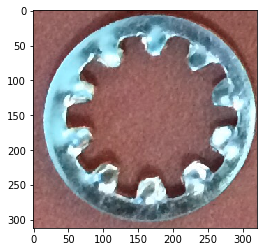

In [5]:
test_part = parts[0]

x, y, w, h = test_part

part_img = original[y:y+h, x:x+w]

plt.imshow(part_img)